,Batch,x1,x2,y
0,0.0,2.204358,-3.241117,-6562.954248
1,0.0,9.246825,6.145304,-629844.664918
2,0.0,4.606343,-0.091371,-45423.628672
3,0.0,-2.530880,9.294155,-846.985999
4,0.0,-4.431369,0.851464,-35319.248621
...,...,...,...,...
105,10.0,-2.024845,6.980111,-838.654287
106,10.0,2.311917,2.698049,-702.336202
107,10.0,1.331238,6.120098,-1890.536279
108,10.0,1.227249,1.446906,-0.402492


,x1,x2,y
0,2.204358,-3.241117,-6562.954248
1,9.246825,6.145304,-629844.664918
2,4.606343,-0.091371,-45423.628672
3,-2.530880,9.294155,-846.985999
4,-4.431369,0.851464,-35319.248621
...,...,...,...
105,-2.024845,6.980111,-838.654287
106,2.311917,2.698049,-702.336202
107,1.331238,6.120098,-1890.536279
108,1.227249,1.446906,-0.402492


,x1,x2
0.2,0.928685,0.071315


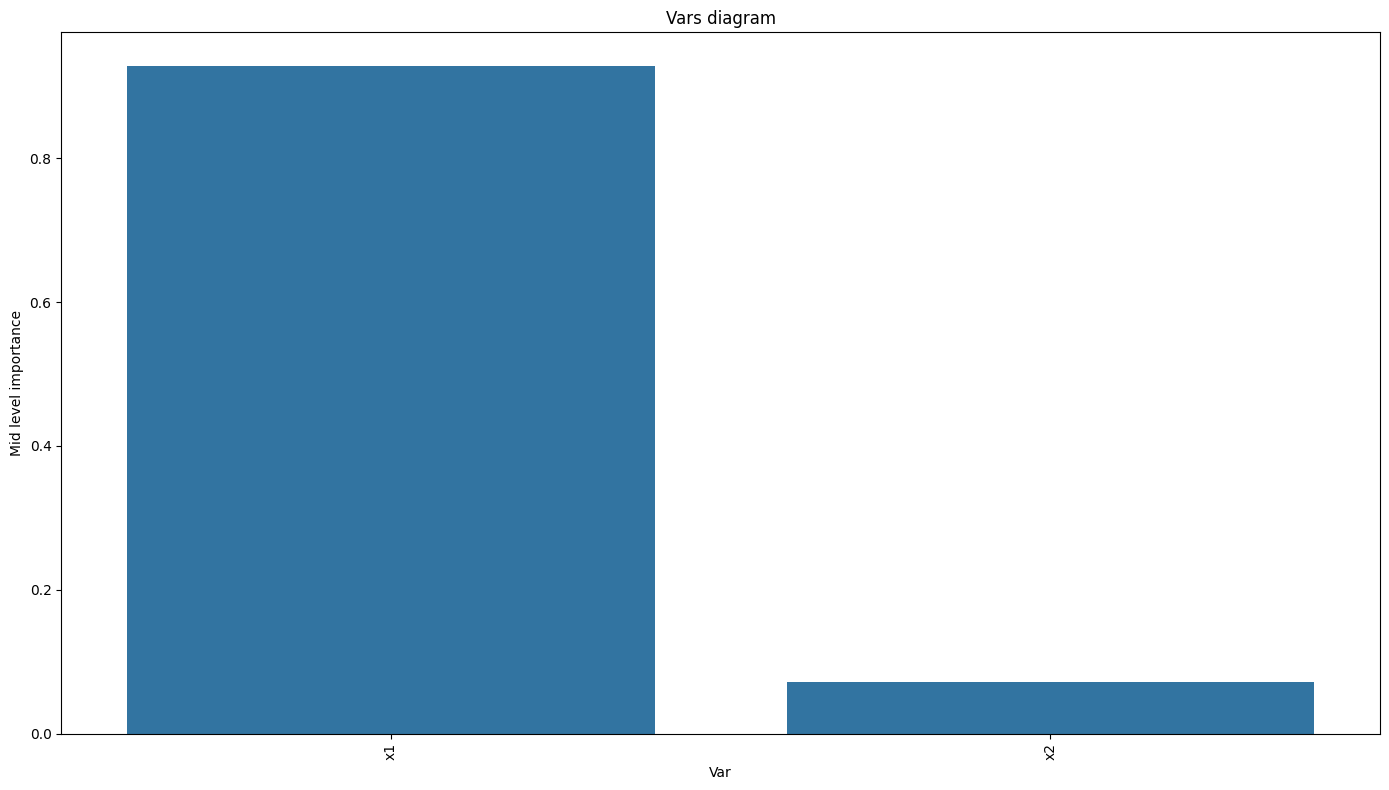

In [67]:
from bayesian_optimization import BayesianOptimization
import pandas as pd 
from botorch.test_functions import Ackley
from botorch.test_functions import Levy 
from botorch.test_functions import Rosenbrock
from varstool import DVARS
import seaborn as sns
import matplotlib.pyplot as plt

# Variables that determine the size of the dataset
N_INITIAL = 10
EPOCHS = 10
BATCH_SIZE = 10
DIM = 2
LOWER = -5
UPPER = 10

optimizer = BayesianOptimization(fun=Rosenbrock(dim=DIM,negate=True), 
                                 batch_size=BATCH_SIZE, 
                                 dim=DIM, 
                                 epochs=EPOCHS, 
                                 n_init=N_INITIAL, 
                                 lower_bound=LOWER,
                                 upper_bound=UPPER,
                                 seed=5,
                                 acqf_type='qUCB')

x_max, y_max = optimizer.run()
data = optimizer.get_data()
full = optimizer.format(data, dim=DIM, n_init=N_INITIAL, batch_size=BATCH_SIZE, epochs=EPOCHS)
display(full)

vars_data = full.drop(columns=['Batch'])

display(vars_data)
vars_data.to_csv('vars_data.csv', index=False)
h = 0.3
experiment = DVARS(data_file = 'vars_data.csv',
                   outvarname = 'y',
                   ivars_range = h,
                   phi0=1,
                   phi_max=1e6,
                   tol = 1e-6,
                   correlation_func_type='linear',
                   report_verbose=False)

experiment.run()
display(experiment.ratios)
 
data = pd.DataFrame(experiment.ratios, index=[h])
data = data.T.sort_values(by=h, ascending=False).T

# Plotting the ratios
plt.figure(figsize=(14, 8))
sns.barplot(x=data.columns, y=data.iloc[0])
plt.xticks(rotation=90)
plt.title('Vars diagram')
plt.xlabel('Var')
plt.ylabel('Mid level importance')
plt.tight_layout()

plt.show()

In [42]:
import numpy as np
import torch
from botorch.test_functions import Hartmann
from varstool import VARS, Model

# Define the parameters
DIM = 6
LOWER = 0
UPPER = 1

# Initialize the Hartmann function
hart = Hartmann(dim=DIM, negate=True)

# Set the bounds of the function
hart.bounds[0, :].fill_(LOWER)
hart.bounds[1, :].fill_(UPPER)

# Define a wrapper for the Hartmann function to match the expected input format for VARS
def hartmann_function(X):
    if isinstance(X, pd.DataFrame):
        X = torch.tensor(X.values, dtype=torch.float32)
    elif not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    
    # Assuming hart(X) returns a single scalar
    result = hart(X).item()
    return result

# Create the Model object with the Hartmann function
model = Model(func=hartmann_function)

my_parameters = { 'x1': [ LOWER, UPPER ], 
                  'x2': [ LOWER, UPPER ], 
                  'x3': [ LOWER, UPPER ],
                  'x4': [ LOWER, UPPER ], 
                  'x5': [ LOWER, UPPER ], 
                  'x6': [ LOWER, UPPER ], }


# Initialize the VARS object
vars = VARS(parameters= my_parameters,
                    num_stars      = 100,
                    delta_h        = 0.1,
                    ivars_scales   = (0.1, 0.3, 0.5),
                    sampler        = 'lhs',
                    seed           = 123456789,
                    model          = model,
                    bootstrap_flag = True,
                    bootstrap_size = 100,
                    bootstrap_ci   = 0.9,
                    grouping_flag  = True,
                    num_grps       = 2,
                    report_verbose = True,
                    )

# Run the analysis
results = vars.run_online()

model evaluation:   0%|          | 0/5500 [00:00<?, ?it/s]/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_17307/3373430391.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = torch.tensor(X, dtype=torch.float32)
bootstrapping and grouping: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]
/Users/dylanschubert/anaconda3/envs/msc_project/lib/python3.12/site-packages/varstool/sensitivity_analysis/vars_funcs.py:989: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_bs_sobol_ranking[param].eq(st_factor_ranking[param][0]).sum() / bootstrap_size)


In [47]:
# IVARS from Experiment 1
results.ivars

AttributeError: 'NoneType' object has no attribute 'ivars'

In [44]:
# IVARS from Experiment 1
cols = results.parameters.keys()
results.ivars[cols]

AttributeError: 'NoneType' object has no attribute 'parameters'

In [29]:
def ishigami(x, a=7, b=0.1):
    '''Ishigami test function'''
    # check whether the input x is a dataframe
    
    if not isinstance(x, (pd.core.frame.DataFrame, pd.core.series.Series, np.ndarray, list)):
        raise TypeError('`x` must be of type pandas.DataFrame, numpy.ndarray, pd.Series, or list')
    
    if len(x) > 3:
        raise ValueError('`x` must have only three arguments at a time')
    
    return np.sin(x[0]) + a*(np.sin(x[1])**2) + b*(x[2]**4)*np.sin(x[0])

In [30]:
ishigami_model = Model(ishigami)

In [31]:
x=pd.Series({#name  #value
             'x1'   : 0 ,
             'x2'   : 0 ,
             'x3'   : 0 ,
             })
ishigami_model(x)

/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_17307/2295546794.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sin(x[0]) + a*(np.sin(x[1])**2) + b*(x[2]**4)*np.sin(x[0])


0.0

In [32]:
# Define Experiment 1

my_parameters = { 'x1': [ -3.14, 3.14 ], 
                  'x2': [ -3.14, 3.14 ], 
                  'x3': [ -3.14, 3.14 ], }

experiment_1 = VARS(parameters     = my_parameters,
                    num_stars      = 100,
                    delta_h        = 0.1,
                    ivars_scales   = (0.1, 0.3, 0.5),
                    sampler        = 'lhs',
                    seed           = 123456789,
                    model          = ishigami_model,
                    bootstrap_flag = True,
                    bootstrap_size = 100,
                    bootstrap_ci   = 0.9,
                    grouping_flag  = True,
                    num_grps       = 2,
                    report_verbose = True,
                    )

In [33]:
experiment_1.run_online()

model evaluation:   0%|          | 0/2800 [00:00<?, ?it/s]/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_17307/2295546794.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sin(x[0]) + a*(np.sin(x[1])**2) + b*(x[2]**4)*np.sin(x[0])
bootstrapping and grouping: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]
/Users/dylanschubert/anaconda3/envs/msc_project/lib/python3.12/site-packages/varstool/sensitivity_analysis/vars_funcs.py:989: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_bs_sobol_ranking[param].eq(st_factor_ranking[param][0]).sum() / bootstrap_size)


In [46]:
print(experiment_1.ivars)

           x1        x2        x3
0.1  0.066097  0.229198  0.059902
0.3  0.961455  2.147283  0.574615
0.5  3.313248  3.035793  1.461225


In [34]:
# IVARS from Experiment 1
cols = experiment_1.parameters.keys()
experiment_1.ivars[cols]

,x1,x2,x3
0.1,0.066097,0.229198,0.059902
0.3,0.961455,2.147283,0.574615
0.5,3.313248,3.035793,1.461225


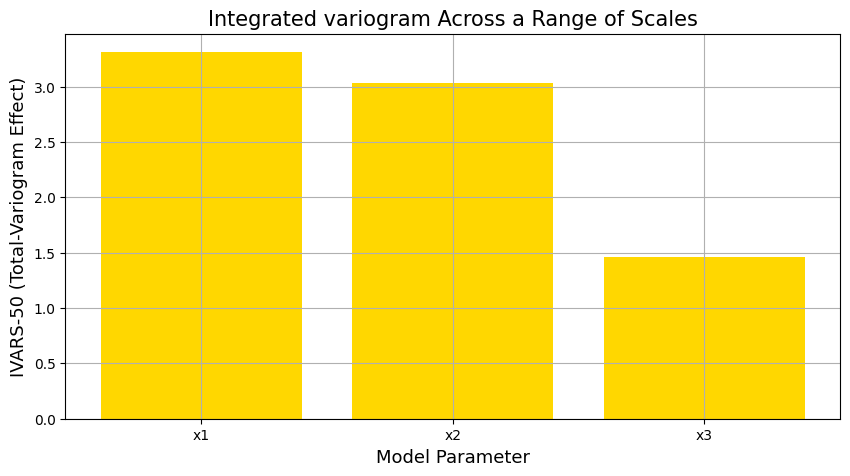

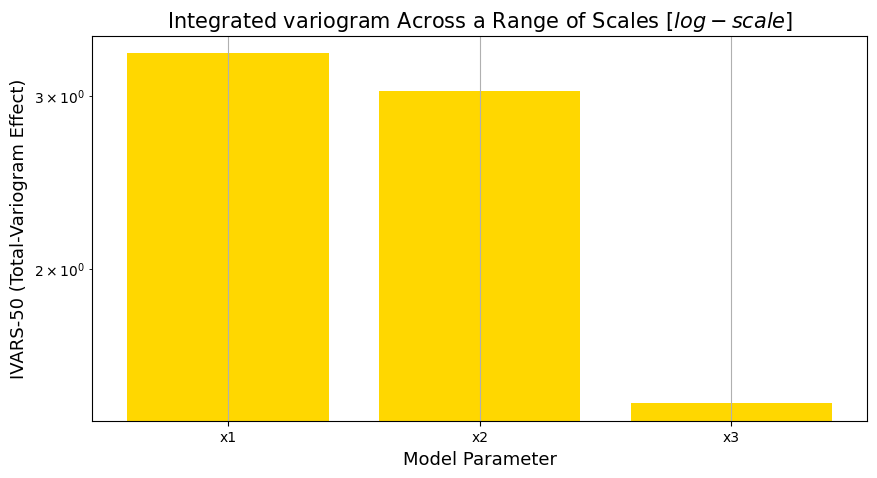

In [35]:
# Plot IVARS from Experiment 1
ivars_scale = 0.5 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_1.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('log')